# Análise exploratória

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import locale
import unidecode
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from datetime import datetime, date
from deep_translator import GoogleTranslator
from collections import defaultdict
from collections import Counter

In [2]:
df = pd.read_parquet('dados/articles2.parquet')

# verificando as dimensões do DataFrame
print("Variáveis:\t{}\nEntradas:\t{}".format(df.shape[1], df.shape[0]))

Variáveis:	13
Entradas:	17780


In [3]:
# identificar o tipo de cada variável
display(df.dtypes)

title                object
title_alt            object
authors              object
advisor1             object
keywords             object
date         datetime64[ns]
publisher            object
campus               object
citation             object
resumo               object
abstract             object
uri                  object
pdf_uri              object
dtype: object

# Exploração dos Dados
## 1.1 Dicionário de Dados¶

   * **title:** título da monografia em português
   * **title_alt** título do monografia em inglês, quando disponível
   * **authors:** autores da monografia 
   * **advisor1:** orientadores
   * **keywords:** palavras chave da monografia
   * **date:** data de publicação
   * **publisher:** editora de publicação
   * **campus:** campus da publicação
   * **citation:** citações
   * **resumo:** resumo da monografia
   * **abstract:** resumo da monografia em inglês
   * **uri:** link para acesso ao artigo
   * **pdf_uri:** link para acesso ao pdf

In [4]:
df = pd.read_parquet('dados/articles2.parquet')
df.tail(3)

,title,title_alt,authors,advisor1,keywords,date,publisher,campus,citation,resumo,abstract,uri,pdf_uri
unique_id,,,,,,,,,,,,,
26006,Influência das etapas de branqueamento e tempe...,Influence of bleaching steps and drying temper...,"[Nomura, Vitor Hiroyuki]","Johann, Gracielle","[Branqueamento, Secagem, Modelos matemáticos, ...",2021-05-28,Universidade Tecnológica Federal do Paraná,Pato Branco,"NOMURA, Vitor Hiroyuki. Influência das etapas ...",A erva-mate (Ilex paraguariensis) é uma planta...,Yerba mate (Ilex paraguariensis) is a plant th...,http://repositorio.utfpr.edu.br/jspui/handle/1...,https://repositorio.utfpr.edu.br/jspui/bitstre...
28828,Desenvolvimento e validação de simulador de to...,Development and validation of an optical tomog...,"[Bernardelli, Rafael Sturaro]","Silva, Marco Jose da","[Escoamento bifásico, Tomografia óptica, Métod...",2021-05-31,Universidade Tecnológica Federal do Paraná,Curitiba,"BERNARDELLI, Rafael Sturaro. Desenvolvimento e...",Escoamentos bifásicos estão presentes em diver...,Two-phase flows are found in several industria...,http://repositorio.utfpr.edu.br/jspui/handle/1...,https://repositorio.utfpr.edu.br/jspui/bitstre...
25530,Proposta de um modelo teórico para o planejame...,Proposal for a theoretical model for planning ...,"[Schiavon, Giovanni Luigi Ferreira]","Pagani, Regina Negri","[Cidades e vilas, Planejamento urbano, Adminis...",2021-05-28,Universidade Tecnológica Federal do Paraná,Ponta Grossa,"SCHIAVON, Giovanni Luigi Ferreira. Proposta de...",As aglomerações urbanas são um fenômeno cresce...,Urban agglomerations are a growing phenomenon ...,http://repositorio.utfpr.edu.br/jspui/handle/1...,https://repositorio.utfpr.edu.br/jspui/bitstre...


## 1.2 Porcentagem de valores faltantes

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(13)

,Total,%
title_alt,6001,33.8
abstract,427,2.4
advisor1,203,1.1
publisher,160,0.9
resumo,98,0.6
campus,1,0.0
citation,1,0.0
title,0,0.0
authors,0,0.0
keywords,0,0.0


Como podemos visualizar, **7 das nossa 13 variáveis têm valores faltantes**, porém destes a que mais se destaca é a **title_alt**, que possui **33,8%** dos valores faltantes.

Uma vez que a **title_alt** é apenas o campo do title traduzido para inglês iremos deconsiderar essa coluna de nossa análise. Já os demais campos, iremos traduzir o **resumo** e o **abstract** para preencher respectivamente os valores faltantes dos campos **abstract** e **resumo**. 

In [6]:
# Tradutores configurados
tradutor_pt_en = GoogleTranslator(source='pt', target='en')
tradutor_en_pt = GoogleTranslator(source='en', target='pt')

# 1. Remover a coluna'title_alt'
df.drop(columns=['title_alt'], inplace=True)

# 2. Preencher 'advisor1' nulo com "Não Informado"
df['advisor1'] = df['advisor1'].fillna('Não Informado')

# 3. Traduzir 'resumo' para 'abstract' (se 'abstract' estiver nulo e 'resumo' não for nulo)
def traduzir_para_ingles(row):
    if pd.isna(row['abstract']) and pd.notna(row['resumo']):
        try:
            return tradutor_pt_en.translate(row['resumo'])
        except:
            return np.nan
    return row['abstract']

df['abstract'] = df.apply(traduzir_para_ingles, axis=1)

# 4. Traduzir 'abstract' para 'resumo' (se 'resumo' estiver nulo e 'abstract' não for nulo)
def traduzir_para_portugues(row):
    if pd.isna(row['resumo']) and pd.notna(row['abstract']):
        try:
            return tradutor_en_pt.translate(row['abstract'])
        except:
            return np.nan
    return row['resumo']

df['resumo'] = df.apply(traduzir_para_portugues, axis=1)

Como podemos visualizar abaixo, tivemos uma **redução nos valores nullos** no data frame após a tratatativa dos valores faltantes. 

In [7]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(13)

,Total,%
publisher,160,0.9
resumo,62,0.3
abstract,62,0.3
campus,1,0.0
citation,1,0.0
title,0,0.0
authors,0,0.0
advisor1,0,0.0
keywords,0,0.0
date,0,0.0


## 1.3 Quantidade de valores únicos em cada coluna

In [8]:
valores_unicos_convertidos = df.apply(lambda col: col.astype(str).nunique())
valores_unicos_convertidos = valores_unicos_convertidos.sort_values(ascending=False)

# Exibir como DataFrame
pd.DataFrame(valores_unicos_convertidos, columns=['Valores Únicos'])

,Valores Únicos
title,17780
uri,17780
pdf_uri,17780
citation,17779
abstract,17712
resumo,17711
keywords,17665
authors,17188
advisor1,3129
date,2023


In [9]:
agrupado = df.groupby(['campus']).size().reset_index(name='quantidade')
agrupado = agrupado.sort_values(by='quantidade', ascending=False)

print(agrupado)

               campus  quantidade
3            Curitiba        6396
9         Pato Branco        2413
10       Ponta Grossa        1665
8          Medianeira        1568
7            Londrina        1293
1        Campo Mourao        1083
4       Dois Vizinhos        1025
2   Cornelio Procopio         589
13             Toledo         527
0           Apucarana         424
5   Francisco Beltrao         417
6          Guarapuava         262
12       Santa Helena         108
11           Reitoria           9


Identificamos **45 locais de publicação distintos**, distribuídos entre **15 campi diferentes**, sendo o campus que mais publicou o de **Curitiba**.


## 2.1 Distribuição de Trabalhos por Ano

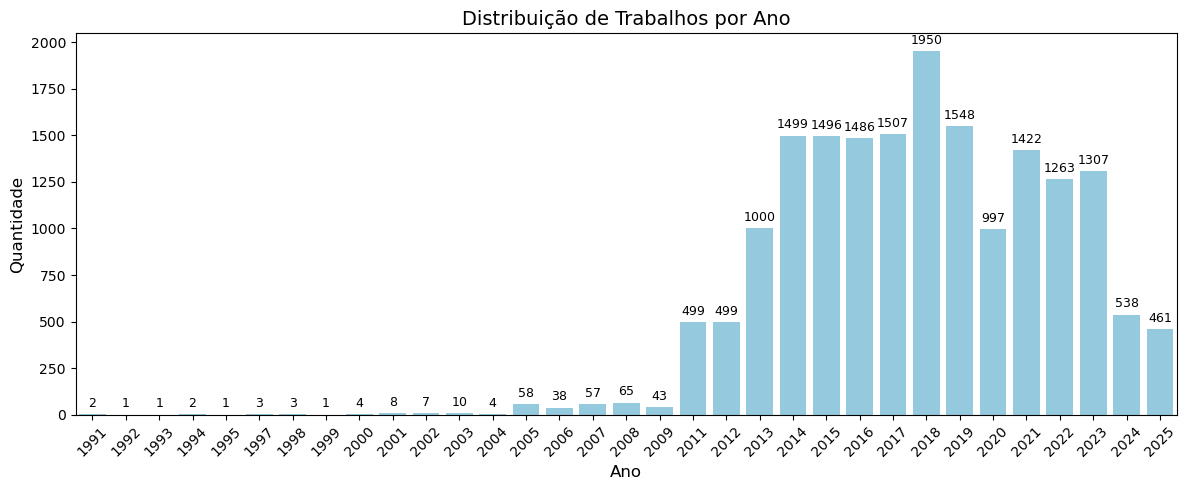

In [10]:
# Processa datas e extrai ano
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Filtra somente registros com ano não nulo
df_filtrado = df[df['year'].notna()]
anos_ordenados = sorted(df_filtrado['year'].unique())

# Gera o gráfico com todas as barras
plt.figure(figsize=(12, 5))
ax = sns.countplot(data=df_filtrado, x='year', order=anos_ordenados, color='skyblue')

# Adiciona os rótulos com a contagem
ax.bar_label(ax.containers[0], fontsize=9, padding=3)

plt.title('Distribuição de Trabalhos por Ano', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Em **2020, observa-se uma queda abrupta nas publicações**: de 1.548 (2019) para 997 (2020), o que representa uma redução de aproximadamente 35%.

Esse **recuo** coincide com o início da pandemia de **COVID-19**, que pode ter impactado significativamente os cronogramas de orientação, defesa e entrega de monografias e TCCs.


## 2.2 Distribuição de Trabalhos por Campus

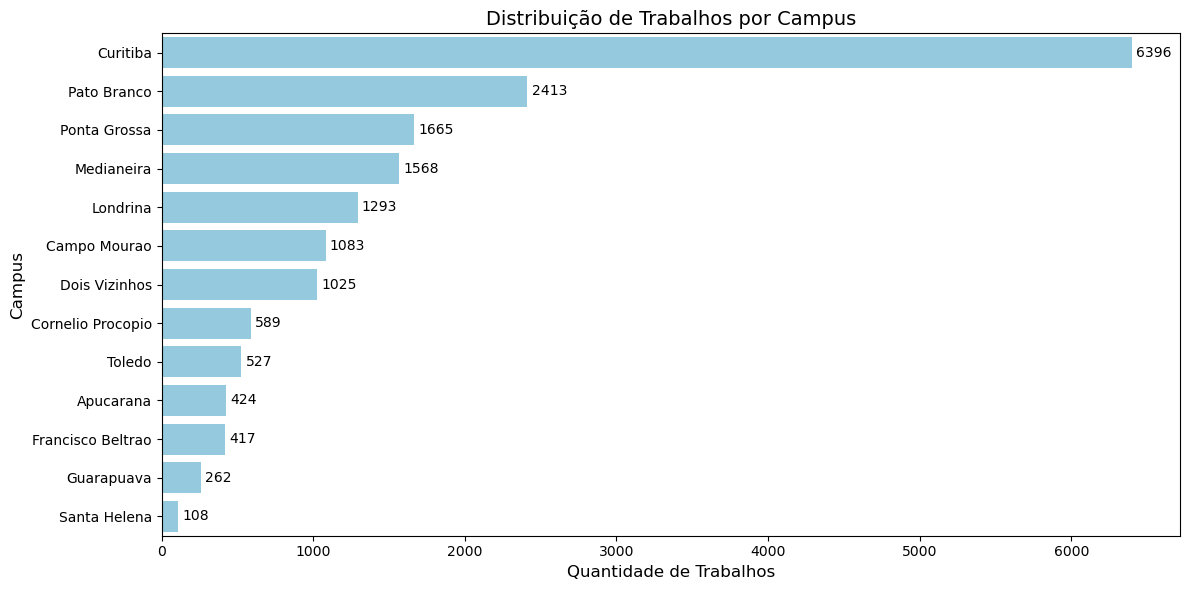

In [11]:
# Filtrar dados (sem Reitoria)
dfc = df[df['campus'] != 'Reitoria']

# Contar quantidade de trabalhos por campus
campus_counts = dfc['campus'].value_counts()

# Criar gráfico
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=dfc,
    y='campus',
    order=campus_counts.index,
    color='skyblue'
)

# Gerar rótulos com os números absolutos
labels = [str(campus_counts[c]) for c in campus_counts.index]

# Adicionar rótulos ao lado das barras
ax.bar_label(ax.containers[0], labels=labels, padding=3, fontsize=10)

# Estética
plt.title('Distribuição de Trabalhos por Campus', fontsize=14)
plt.xlabel('Quantidade de Trabalhos', fontsize=12)
plt.ylabel('Campus', fontsize=12)
plt.tight_layout()
plt.show()

Observa-se que o Campus **Curitiba** se destaca de forma expressiva na distribuição de trabalhos acadêmicos, contabilizando **6.396 publicações**, o que representa uma concentração significativa em relação aos demais campi. Em segundo lugar aparece Pato Branco, com 2.413 publicações, seguido por Ponta Grossa (1.665) e Medianeira (1.568).
Essa distribuição sugere uma disparidade considerável na produção acadêmica entre os campi, sendo que Curitiba apresenta um volume de publicações aproximadamente 2,5 vezes maior que o segundo colocado, e cerca de 60 vezes maior que o campus com menor volume, Santa Helena (108 trabalhos).
Esse padrão pode estar relacionado a fatores como:
* **Diferentes tamanhos das unidades acadêmicas;**
* **Maior número de cursos ofertados em Curitiba;**

## 2.3 Tamanho dos Resumos (em palavras)

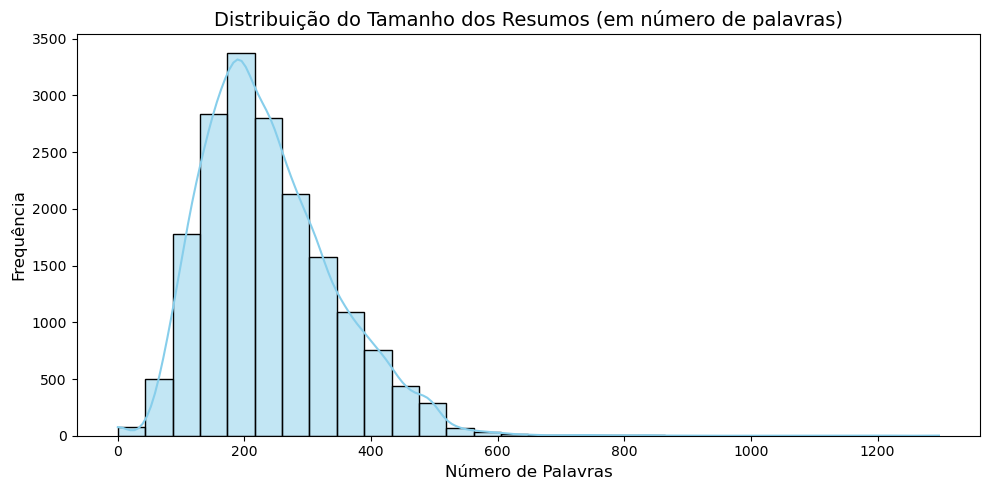

In [12]:
df['resumo_length'] = df['resumo'].fillna('').apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['resumo_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição do Tamanho dos Resumos (em número de palavras)', fontsize=14)
plt.xlabel('Número de Palavras', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.tight_layout()
plt.show()

### Distribuição do Tamanho dos Resumos
A distribuição do número de palavras nos resumos apresenta um perfil assimétrico à direita (positivamente enviesado), o que indica que a maioria dos resumos tende a concentrar-se em faixas menores de tamanho, com uma cauda longa estendendo-se para maiores quantidades de palavras.

### Principais Observações:
* O pico de frequência ocorre no intervalo entre 173 e 217 palavras, indicando que essa é a faixa de tamanho de resumo mais comum entre os autores.
* A grande maioria dos resumos contém entre 100 e 400 palavras, o que está em conformidade com recomendações acadêmicas típicas para resumos de monografias e trabalhos científicos.
* Há casos atípicos (outliers) com resumos superiores a 600 palavras, chegando até mais de 1.200 palavras, o que pode indicar:
* Resumos excessivamente longos que não seguem padronização.
* A distribuição tem uma cauda longa, reforçando a necessidade de atenção a valores extremos.

## 1.4 Nuvem de Palavras dos Resumos

In [13]:
# Baixar stopwords se ainda não tiver
nltk.download('stopwords')

# Stopwords padrão do português
stopwords_pt = set(stopwords.words('portuguese'))

# Stopwords adicionais (personalizadas para remover termos genéricos acadêmicos)
stopwords_custom = stopwords_pt.union({
    # palavras genéricas de artigos
    'trabalho', 'objetivo', 'presente', 'realizado', 'realizar', 'através', 'problema'
    'meio', 'caso', 'estudo', 'utilização', 'tipo', 'análise', 'área', 'empresa'
    'obtenção', 'resultados', 'forma', 'uso', 'modelo', 'técnica', 'estudos'
    'técnicas', 'implementação', 'apresenta', 'desta', 'durante', 'principal',
    'como', 'sendo', 'foi', 'pode', 'poder', 'deve', 'para', 'que', 'com', 'assim'
    'em', 'por', 'um', 'uma', 'nos', 'nas', 'nosso', 'nossa', 'seu', 'sua', 'outro',
    'os', 'as', 'é', 'ao', 'aos', 'no', 'na', 'também', 'mais', 'menos',
    'entre', 'além', 'sobre', 'neste', 'nesta', 'nesse', 'nessa', 'este',
    'esta', 'esse', 'essa', 'qual', 'quando', 'onde', 'até', 'após', 'antes', 'deste',
    'universidade', 'tecnológica', 'federal', 'paraná', 'curso', 'processo', 
    'processos', 'resultado', 'conclusão', 'tema', 'palavras', 'chave', 
    'referencial', 'bibliográfico', 'teóricos', 'pesquisa', 'partir', 'assim', 'ainda', 
    'diferente', 'porém', 'tendo', 'bem', 'Brasil', 'dia', 'parte', 'podem', 
    'realziada', 'necessidade', 'empresa', 'utilizado', 'todo', 'atividade', 'redução',
    'período', 'três', 'meio', 'aula', 'teste', 'base', 'cada', 'maior', 'produto', 'aluno',
    'fim', 'tanto', 'obtido', 'utilizado', 'e', 'curitiba', 'pr', '-', 'of', 'and', 'analise',
    'controle', 'parana', 'aspects'
})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


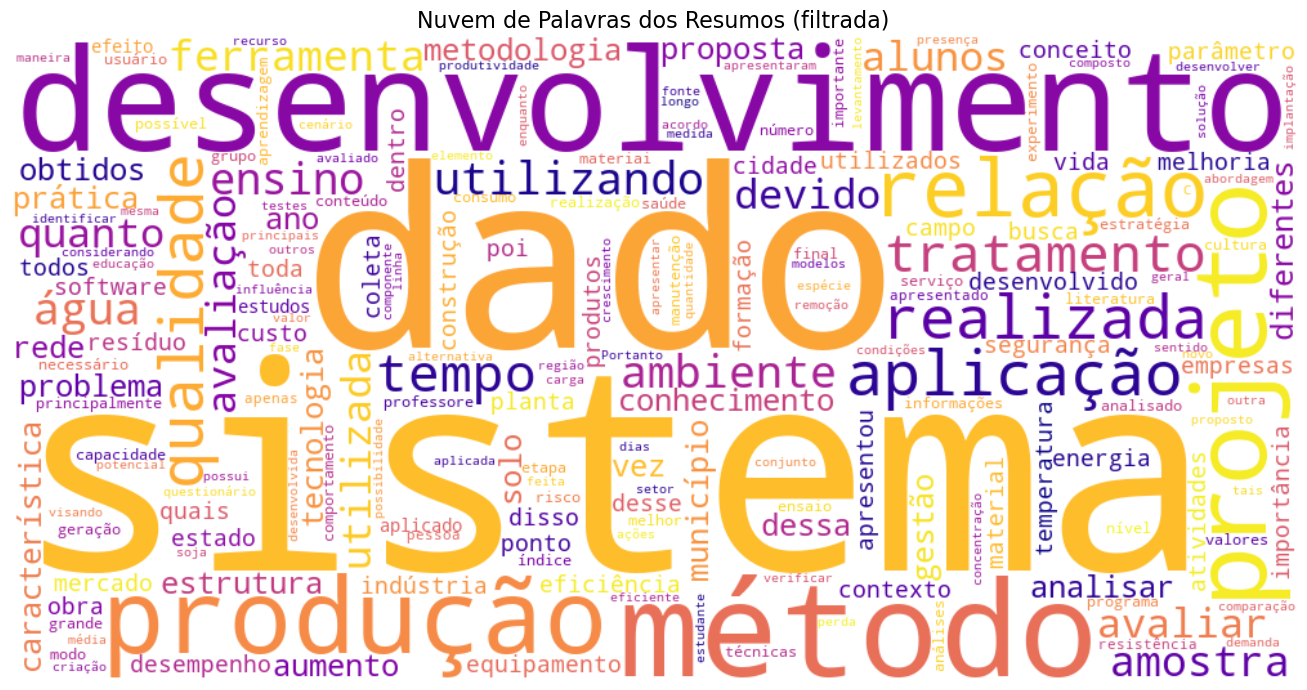

In [14]:
# Gerar texto completo
texto_resumos = " ".join(df['resumo'].dropna().astype(str).values)

# Criar nuvem com stopwords
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='plasma',
    stopwords=stopwords_custom,
    max_words=200
).generate(texto_resumos)

# Exibir
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nuvem de Palavras dos Resumos (filtrada)', fontsize=16)
plt.tight_layout()
plt.show()

## 4.5 Nuvem de Palavras das Palavras Chaves

In [15]:
kw_list = []
kw_dict = defaultdict(set)

def proccess_keyword(kw):
    kw = kw.strip()
    kw = unidecode.unidecode(kw)
    kw = kw.lower()
    return kw

def keyword_generator(kws):
    for kw in kws:
        kw = proccess_keyword(kw)

        # Extrai "tema - subtitulo"
        for topic, subtopic in re.findall(r'([\w\s-]+)\s+-\s+([\w\s-]+)', kw):
            yield from topic.split()
            yield from subtopic.split()

        # Extrai "termo (traducao)"
        for topic, subtopic in re.findall(r'([\w\s]+)\(([\w\s]+)\)', kw):
            yield from topic.split()
            yield from subtopic.split()

        # Dividir palavras compostas também aqui
        for word in kw.split():
            yield word

# Recriar kw_list
for index, row in df.iterrows():
    if isinstance(row['keywords'], (list, tuple, np.ndarray)):
        for kw in keyword_generator(row['keywords']):
            if kw not in kw_dict[index]:
                kw_dict[index].add(kw)
                kw_list.append((index, kw))

print("Itens em kw_list:", len(kw_list))

Itens em kw_list: 297379


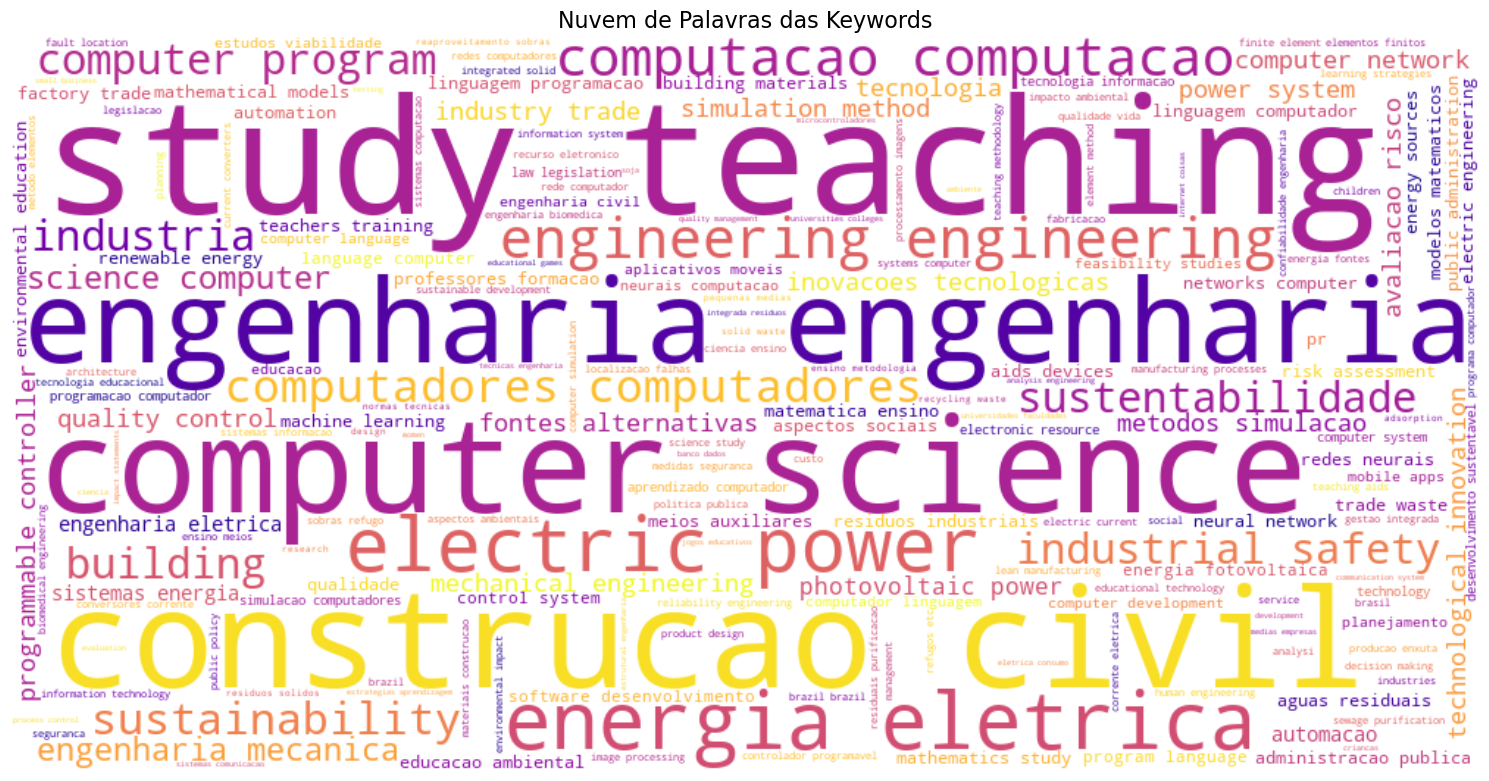

In [16]:
# 2. Extrair palavras tratadas
keywords_processadas = [
    kw for _, kw in kw_list
    if isinstance(kw, str)
    and len(kw.strip()) > 2
    and kw.strip().lower() not in stopwords_custom
]

# 3. Criar texto unificado
texto_keywords = " ".join(keywords_processadas)

# 4. Gerar nuvem de palavras
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='plasma',
    max_words=200
).generate(texto_keywords)

# 5. Exibir
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras das Keywords", fontsize=16)
plt.tight_layout()
plt.show()

## 4.6 Countagem quantidade de autores

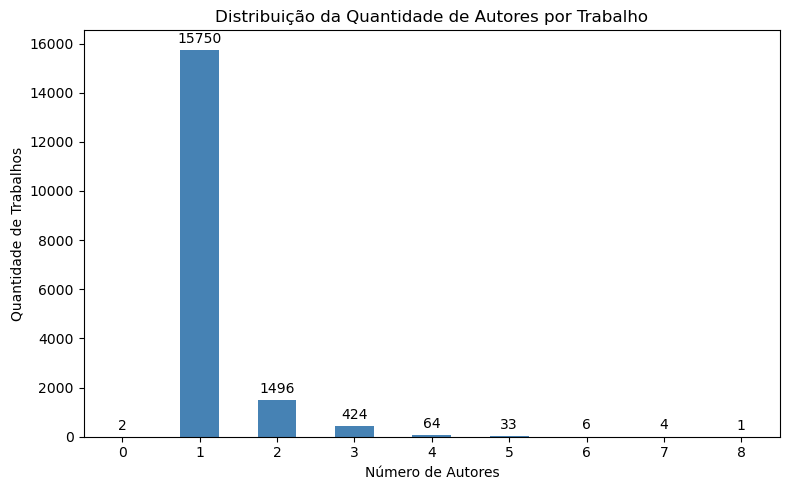

In [17]:
# Converter 'authors' de np.ndarray para list
df['authors'] = df['authors'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Contar número de autores por trabalho
df['num_autores'] = df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Gerar gráfico com valores em cima das barras
plt.figure(figsize=(8, 5))
ax = df['num_autores'].value_counts().sort_index().plot(kind='bar', color='steelblue')

# Adicionar os rótulos acima das barras
ax.bar_label(ax.containers[0], fontsize=10, padding=3)

plt.title("Distribuição da Quantidade de Autores por Trabalho")
plt.xlabel("Número de Autores")
plt.ylabel("Quantidade de Trabalhos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
for uri in df[df['num_autores'] == 0]['uri']:
    print(uri)

http://repositorio.utfpr.edu.br/jspui/handle/1/2187
http://repositorio.utfpr.edu.br/jspui/handle/1/13862


Segue algumas observações:

* Foram identificados dois trabalhos em que o campo autor está em branco.
* De forma geral, a maioria dos trabalhos apresenta entre **1 e 2 autores**, o que representa aproximadamente **97%** do total. Os **3%** restantes correspondem a casos menos frequentes, entre **3 e 8 autores**.



## 4.7 Frequência das keywords na base completa

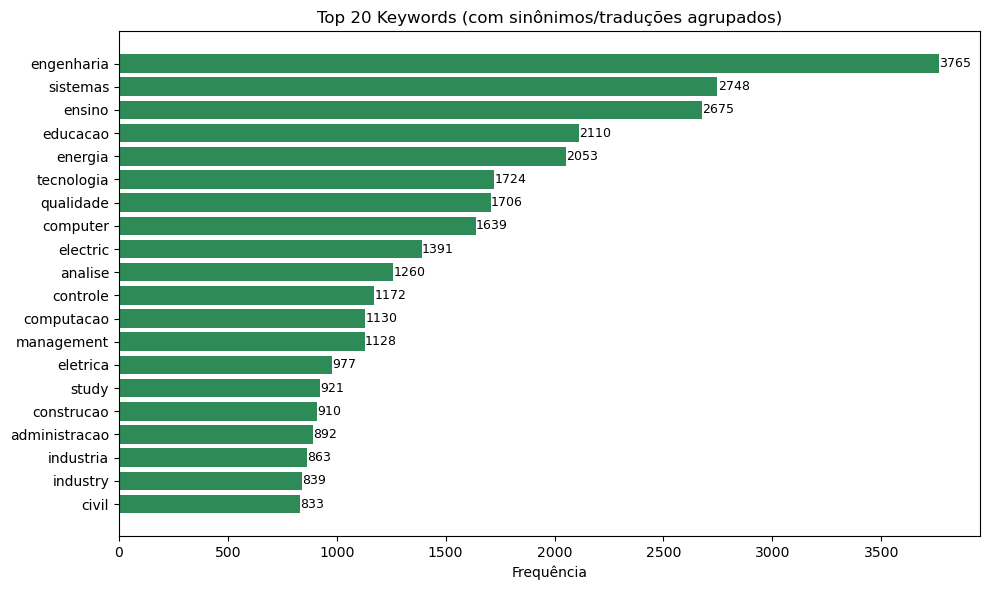

In [19]:
# Dicionário de agrupamento
mapa_traducao = {
    'study and teaching': 'estudo e ensino',
    'teaching': 'ensino',
    'engineering': 'engenharia',
    'analysis': 'analise',
    'sustainability': 'sustentabilidade',
    'computer science': 'computacao',
    'software': 'computacao',
    'building': 'construcao civil',
    'control': 'controle',
    'power': 'energia',
    'systems': 'sistemas',
    'education': 'educacao',
    'quality': 'qualidade',
    'technology': 'tecnologia'
}

# Contagem e transformação
kw_freq = Counter([
    kw for _, kw in kw_list 
    if kw not in stopwords_custom
])
df_kw_freq = pd.DataFrame(kw_freq.items(), columns=['keyword', 'frequencia'])
df_kw_freq['keyword_padronizada'] = df_kw_freq['keyword'].apply(lambda x: mapa_traducao.get(x, x))

# Agrupamento final
df_kw_freq_final = (
    df_kw_freq.groupby('keyword_padronizada')['frequencia']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .head(20)
)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.barh(df_kw_freq_final['keyword_padronizada'], df_kw_freq_final['frequencia'], color='seagreen')
plt.xlabel("Frequência")
plt.title("Top 20 Keywords (com sinônimos/traduções agrupados)")
plt.gca().invert_yaxis()

# Rótulos nas barras
for i, v in enumerate(df_kw_freq_final['frequencia']):
    plt.text(v + 1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

* **Engenharia** se destaca, sendo a palavras chave que mais aparece na base de dados
* Em segundo lugar está  **sistemas** seguida de **ensino** e **educação**.

## 4.8 Keywords mais freqêntes em períodos de tempo de 5 em 5 anos

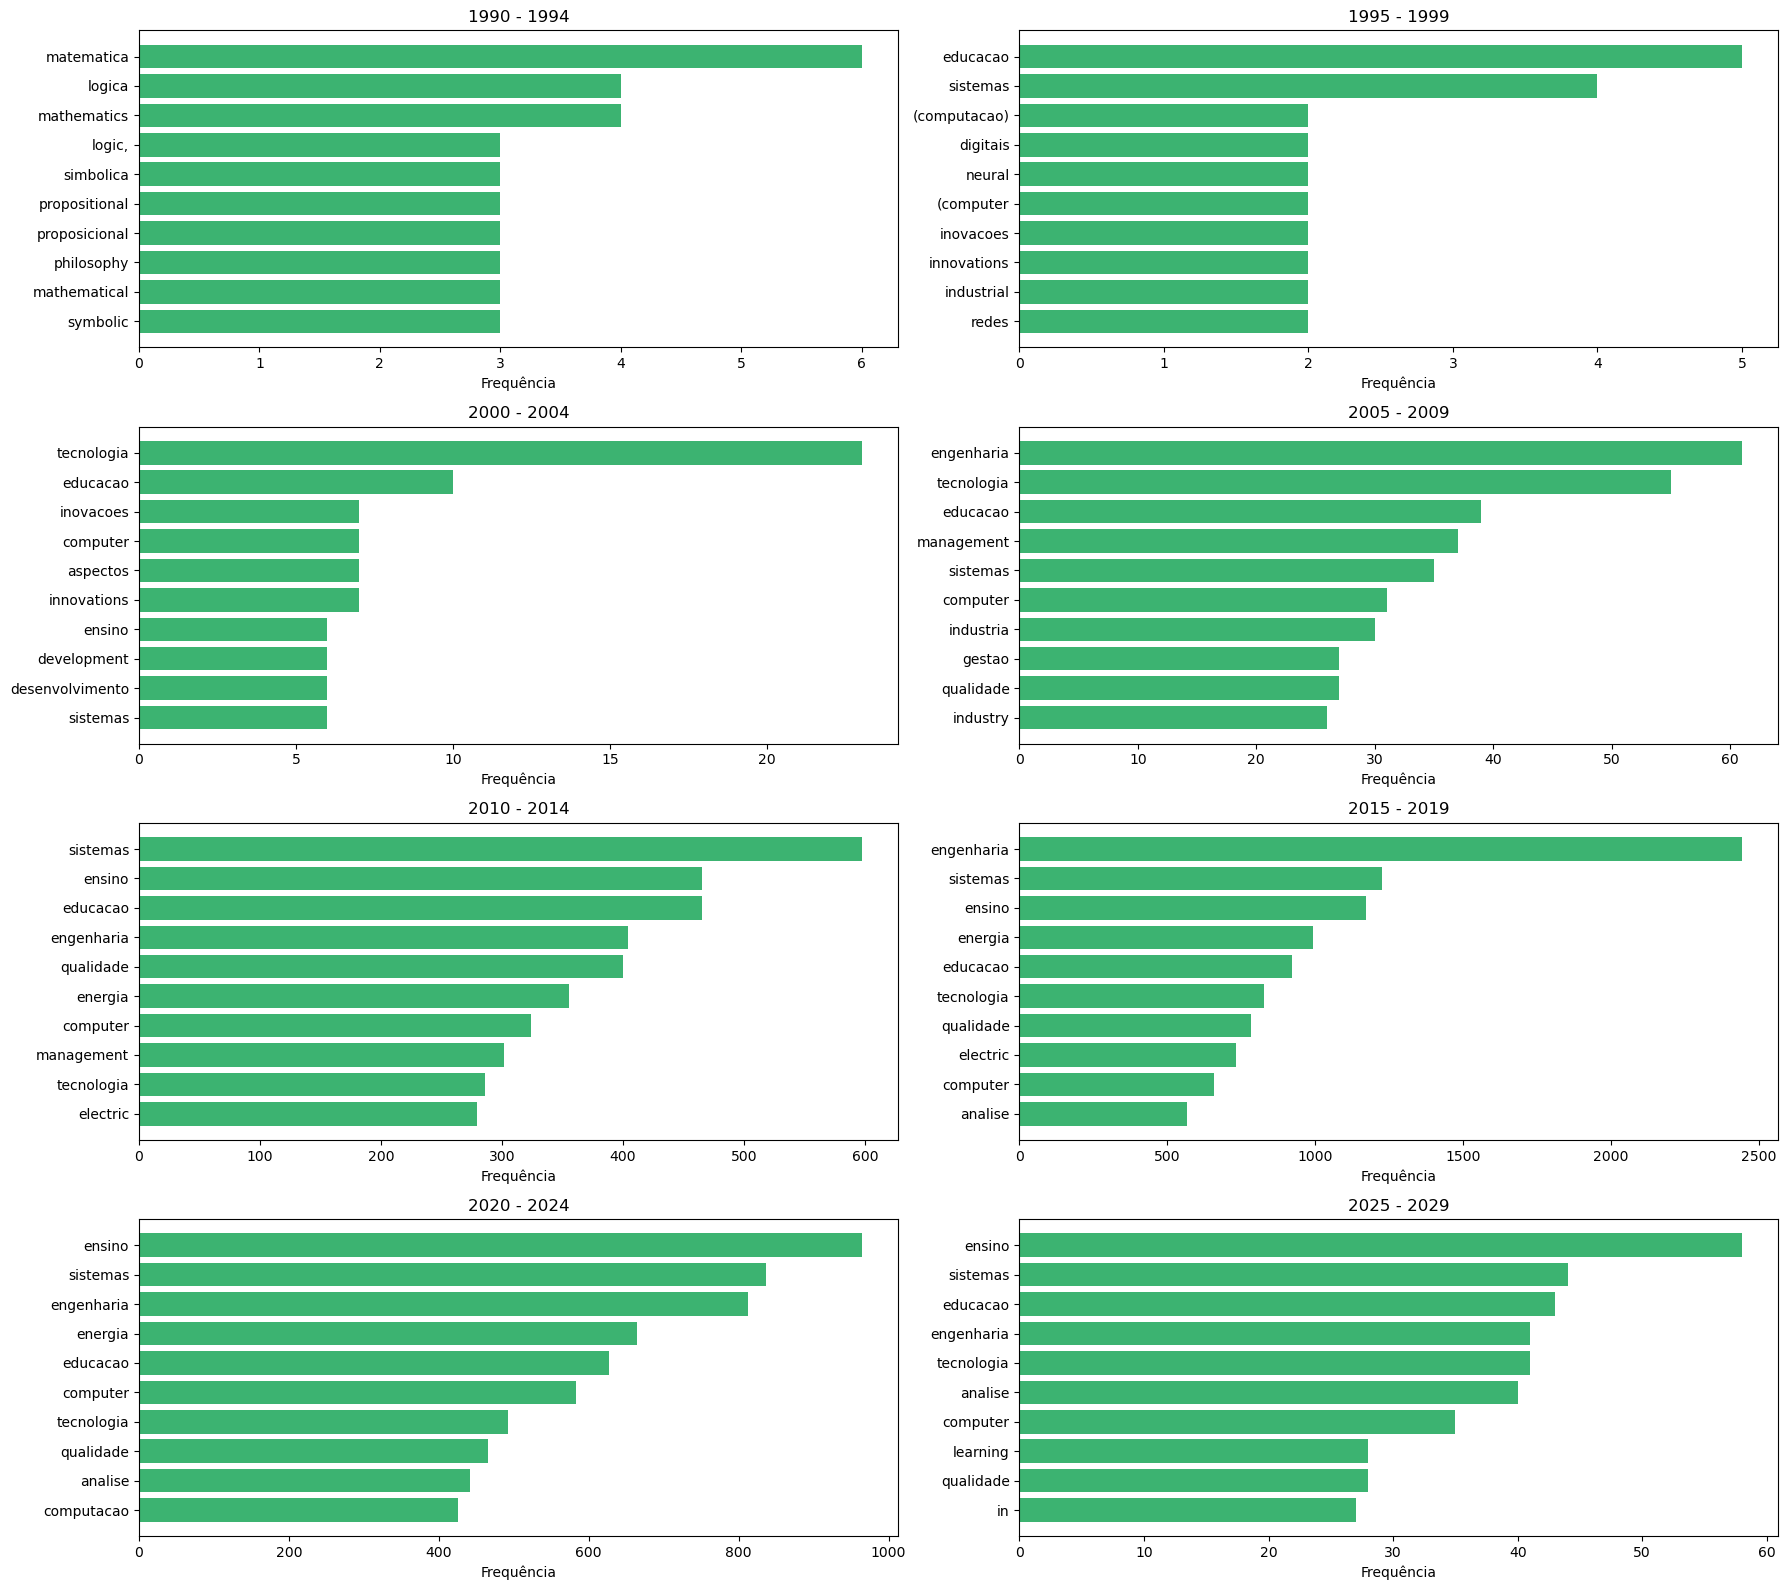

In [20]:
# Gerar intervalos de 5 em 5 anos
start = (df['year'].min() // 5) * 5
end = ((df['year'].max() // 5) + 1) * 5
intervalos = list(range(start, end + 1, 5))

# Preparar grid de subplots
n = len(intervalos) - 1
fig, axs = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(18, 4 * ((n + 1) // 2)))
axs = axs.flatten()  # para acesso via índice simples

for i in range(n):
    ano_ini, ano_fim = intervalos[i], intervalos[i + 1] - 1
    df_intervalo = df[(df['year'] >= ano_ini) & (df['year'] <= ano_fim)]

    kw_intervalo = []
    kw_dict = defaultdict(set)

    for index, row in df_intervalo.iterrows():
        if isinstance(row['keywords'], (list, tuple, np.ndarray)):
            for kw in keyword_generator(row['keywords']):
                if kw not in stopwords_custom:
                    if kw not in kw_dict[index]:
                        kw_dict[index].add(kw)
                        kw_intervalo.append((index, kw))

    kw_freq = Counter([kw for _, kw in kw_intervalo])
    df_kw_freq = pd.DataFrame(kw_freq.items(), columns=['keyword', 'frequencia'])
    df_kw_freq['keyword_padronizada'] = df_kw_freq['keyword'].apply(lambda x: mapa_traducao.get(x, x))

    df_kw_freq_final = (
        df_kw_freq.groupby('keyword_padronizada')['frequencia']
        .sum()
        .sort_values(ascending=False)
        .reset_index()
        .head(10)
    )

    # Plot sem número nas barras
    ax = axs[i]
    ax.barh(df_kw_freq_final['keyword_padronizada'], df_kw_freq_final['frequencia'], color='mediumseagreen')
    ax.set_title(f"{ano_ini} - {ano_fim}")
    ax.set_xlabel("Frequência")
    ax.invert_yaxis()

# Remove gráficos vazios se o número for ímpar
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Entre 1990 e 1994:
* As palavras-chave predominantes estão fortemente ligadas à matemática, como mathematics, matematica, logica simbolica e matematica e propositional calculus.

### Entre 1995 e 1999:
* Observa-se o início de uma transição temática com a introdução de palavras como neural networks e technological innovations.
* Ainda há presença de termos relacionados à educação e à computação, como educacao, computer science e computacao.

### Entre 2000 e 2004:
* Palavras-chave relacionadas à tecnologia, educação e inovação ganham espaço.
* O termo tecnologia torna-se central.

### Entre 2005 e 2009:
* Consolida-se a ênfase em engenharia e tecnológica.
* A computação segue como área recorrente, junto de computer science e computadores.
* É o período com forte presença de termos ligados à administração da tecnologia e ciência aplicada.

### Entre 2010 e 2014:
* A área de sistemas desponta como destaque.
* Há ênfase em ensino e educação.
  
### Entre 2015 e 2019:
* Palavras relacionadas à engenharia dominam a lista.
* Ensino continua sendo um dos tópicos centrais logo após de sistemas, demonstrando a permanência de interesse em pesquisa educacional.

### Entre 2020 e 2024:
* Os termos mais frequentes ensino, seguido de sistemas e engenharia.
* Isso demonstra a permanência do ensino como tema central nos últimos 15 anos.

### Entre 2025 e 2029 (projeções ou dados recentes):
* Ensino continua como tema central, seguido de sistemas e educação.

### **Conclusão geral**:
#### A análise dos dados ao longo do tempo mostra uma evolução temática que acompanha as transformações tecnológicas e sociais:

* **1990–1999: predominância de temas teóricos, com foco em matemática, lógica e fundamentos computacionais.**
* **2000–2009: transição para temas aplicados, com ênfase em tecnologia, inovação, educação e engenharias.**
* **2010–2029: consolidação de ensino como tema central, acompanhado de sistemas e engenharias, refletindo o fortalecimento de abordagens educacionais e tecnológicas integradas.**